In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import csv
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df['mon'] = pd.to_datetime(df['mon'], format='%Y-%m')

In [5]:
df = df.sort_values(by=['CategoryName', 'mon'])

In [6]:
df['prev_month_sales'] = df.groupby('CategoryName')['total_sales'].shift(1)
df_ = df.copy()

In [7]:
df = df.dropna(subset=['prev_month_sales'])

In [8]:
df = df.drop(columns=['mon'])

In [9]:
df = df.dropna()

In [10]:
label_encoder = LabelEncoder()
df['CategoryName'] = label_encoder.fit_transform(df['CategoryName'])

In [11]:
X = df.drop(columns=['total_sales'])
y = df['total_sales']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regression': RandomForestRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

In [14]:
cv_results = {}
pearson_results = {}

cv_folds = 5

In [15]:
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    pearson_corr, _ = pearsonr(y_test, y_pred)
    pearson_results[name] = pearson_corr

    scores = cross_val_score(pipeline, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    mse_scores = -scores
    cv_results[name] = {
        'Mean MSE': np.mean(mse_scores),
        'Standard Deviation': np.std(mse_scores)
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 275, number of used features: 2
[LightGBM] [Info] Start training from score 1308181.269318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [16]:
for name, results in cv_results.items():
    print(f'{name} - Mean MSE: {results["Mean MSE"]:.2f}, Standard Deviation: {results["Standard Deviation"]:.2f}')

print("\nPearson Correlation Coefficients:")
for name, pearson_corr in pearson_results.items():
    print(f'{name}: {pearson_corr:.4f}')

Linear Regression - Mean MSE: 32096958157.71, Standard Deviation: 13091104261.00
Ridge Regression - Mean MSE: 32172856457.31, Standard Deviation: 13068530156.15
Lasso Regression - Mean MSE: 32097032731.32, Standard Deviation: 13091106972.59
Random Forest Regression - Mean MSE: 97315732052.28, Standard Deviation: 122061938280.37
LightGBM - Mean MSE: 80193496733.84, Standard Deviation: 96127084938.14

Pearson Correlation Coefficients:
Linear Regression: 0.8985
Ridge Regression: 0.8983
Lasso Regression: 0.8985
Random Forest Regression: 0.9094
LightGBM: 0.9228


In [18]:
label_encoder = LabelEncoder()
df_['CategoryName'] = label_encoder.fit_transform(df_['CategoryName'])

In [19]:
df_['mon'] = pd.to_datetime(df_['mon'], format='%Y-%m')

df_['year_numeric'] = df_['mon'].dt.year - 2017

def get_season(month):
    if month in [3, 4, 5]:
        return 1  # 봄
    elif month in [6, 7, 8]:
        return 2  # 여름
    elif month in [9, 10, 11]:
        return 3  # 가을
    else:
        return 4  # 겨울

df_['season'] = df_['mon'].dt.month.apply(get_season)

In [20]:
X_ = df_.drop(columns=['total_sales', 'mon'])
y_ = df_['total_sales']

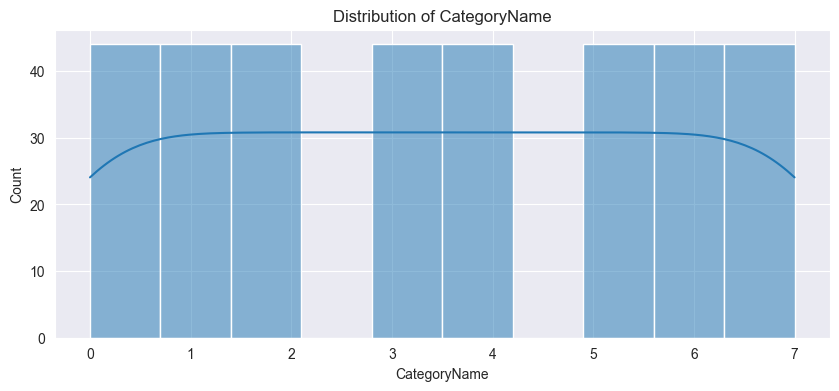

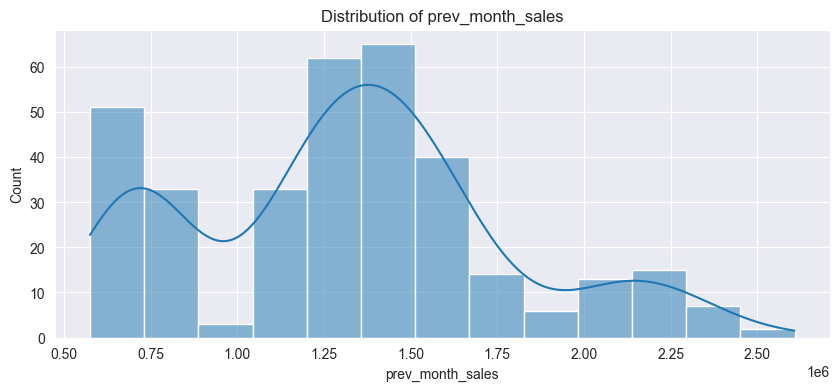

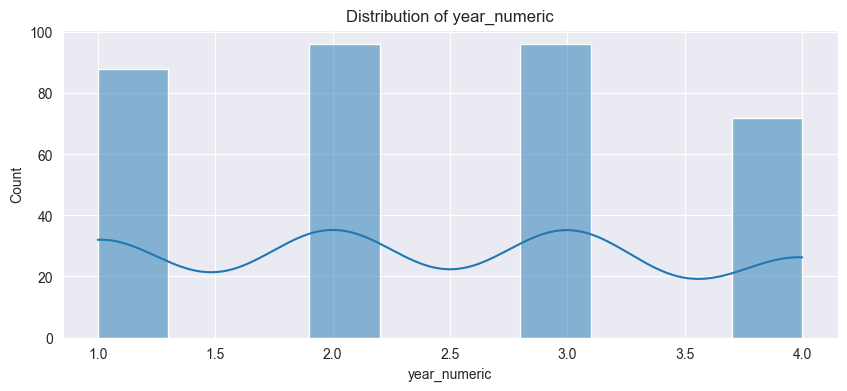

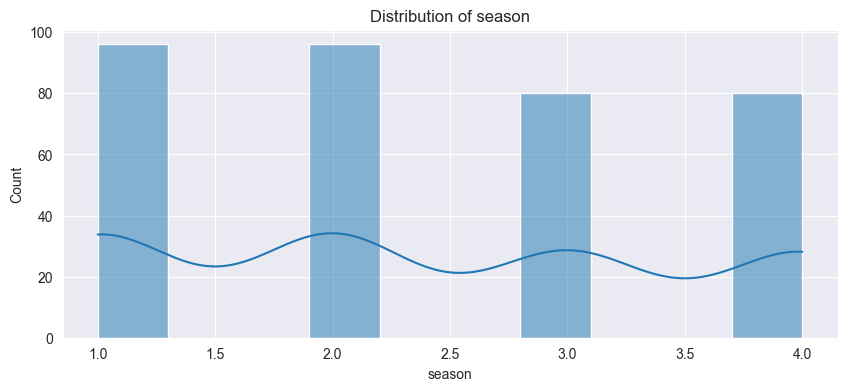

In [21]:
#변수의 분포 확인
for column in X_.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

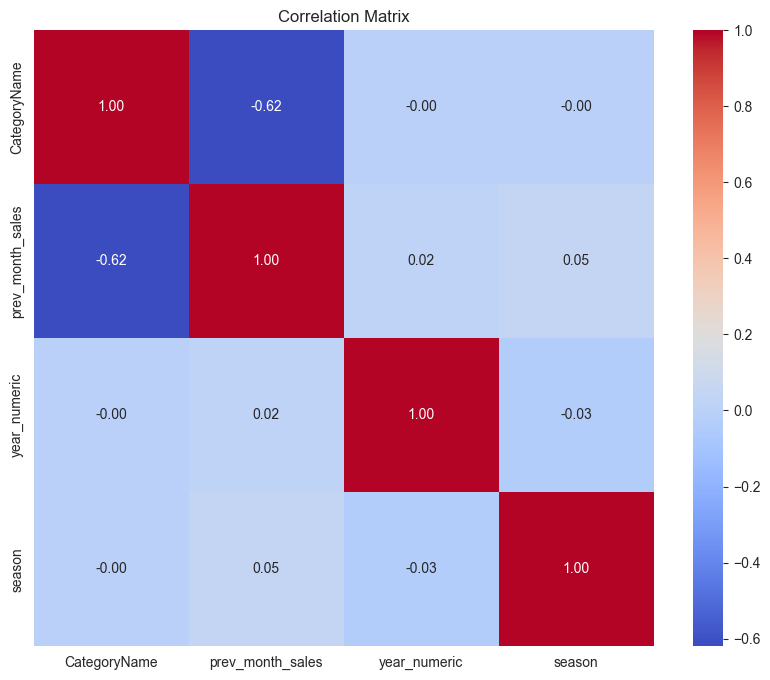

In [22]:
#히트맵
correlation_matrix = X_.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

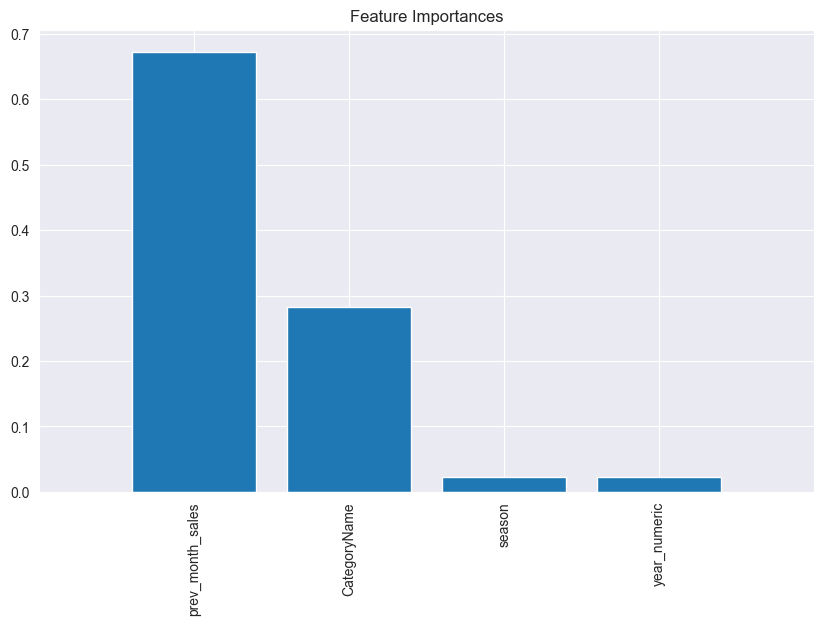

In [24]:
#변수 선택 및 중요도

model_ = RandomForestRegressor()
model_.fit(X_, y_)

importances = model_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_.shape[1]), importances[indices], align='center')
plt.xticks(range(X_.shape[1]), X_.columns[indices], rotation=90)
plt.xlim([-1, X_.shape[1]])
plt.show()